In [1]:
import os
os.chdir("/Users/aliahmadi/Documents/Projects/RNA-Secondary-Structure-Prediction/notebook/EKH-25")

## Imports

In [2]:
from collections import defaultdict
from scipy.linalg import expm
from grammar.pcnf import PCNF
from Bio import Phylo, SeqIO
from copy import deepcopy
from io import StringIO
import networkx as nx
from math import log 
import numpy as np
import shutil
import pickle

___

## Global Variables

In [3]:
predicted_struct = {}

## Pairing Charecters

In [4]:
def get_pair_start(pair_end):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return [val for val in pairing_chars if val[1] == pair_end][0][0]

In [5]:
def is_pair_start(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[0] for p in pairing_chars]

In [6]:
def is_pair_end(char):
    pairing_chars = [("<", ">"), ("(", ")"), ("[", "]"), ("{", "}")]
    return char in [p[1] for p in pairing_chars]

## Create Tree

In [7]:
def create_tree(input_sequences, filename = "./outputs/tree.nwk", draw=True):
  names = list(input_sequences.keys())
  sequences = list(input_sequences.values())
  
  if len(names) <= 2:
    return None
  
  os.mkdir("./tmp")

  if len(names) > 2:
    phylip_file = "./tmp/sequences.phylip"
    with open(phylip_file, "w") as f:
      f.write(f"{len(sequences)} {len(sequences[0])}\n\n")
      for i, seq in enumerate(sequences):
        f.write(f"{names[i]}\t{seq}\n") 
    
    !./phyml -i tmp/sequences.phylip -m GTR
    
    output_tree = Phylo.read(phylip_file + "_phyml_tree.txt", 'newick')

    output_tree.root_at_midpoint()
  
  for index, clade in enumerate(output_tree.find_clades()):
    if not clade.name:
      clade.name = str(index)
  
  shutil.rmtree("./tmp")
  Phylo.write(output_tree, filename, "newick")
  
  Phylo.draw(output_tree)
  
  return output_tree

## Get Mutation Probablities

In [8]:
def get_mutation_probablities(mutation_rate_values, time, order_array = ["A", "C", "G", "U"], gappy=False):
    mutation_rate_matrix = np.zeros((len(order_array), len(order_array)), np.float64)
    
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            mutation_rate_matrix[i_index,j_index] = mutation_rate_values[(i_value, j_value)]
    
    probability_rate_matrix = expm(mutation_rate_matrix * time)
    
    probability_rate_values = defaultdict(float)
    for i_index, i_value in enumerate(order_array):
        for j_index, j_value in enumerate(order_array):
            probability_rate_values[(i_value, j_value)] = probability_rate_matrix[i_index,j_index]
            
    if gappy:      
        if order_array == ["A", "C", "G", "U"]:
            for i_index, i_value in enumerate(order_array):
                for _, j_value in enumerate(["-"]):
                    probability_rate_values[(i_value, j_value)] = 1
        else:
            for i_index, i_value in enumerate(order_array):
                for j_index, j_value in enumerate(['A-', '-A', 'C-', '-C', 'G-', '-G', 'U-', '-U', '--']):
                    if j_value == "--":
                        probability_rate_values[(i_value, j_value)] = 1
                    else:
                        __probability = 0
                        for nocleotid in ["A", "C", "G", "U"]:
                            __j_value = j_value.replace('-', nocleotid)
                            __probability += probability_rate_values[(i_value, __j_value)]
                                
                        probability_rate_values[(i_value, j_value)] = __probability
    
        
    return probability_rate_values

# Check Column

In [9]:
def column_needed(tuple1, tuple2):
    return len(tuple1) == len(tuple2) and all(t1 == t2 for t1, t2 in zip(tuple1, tuple2))

In [10]:
def get_columns(input_sequences, leaf_order):
    columns = defaultdict(list)
    
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        columns[column].append(i)
    return columns

In [11]:
def check_column(input_sequences, column, leaf_order):
    __leaf_order = leaf_order[-len(column):]
    columns = get_columns(input_sequences, __leaf_order)
    
    if len(column[0]) == 1:
        for _column, _places in columns.items():
            if column_needed(column, _column):
                return True
    else:
        for _column1, _places1 in columns.items():
            left_column = tuple(
                    pair[0] for pair in column if pair
            )
            if column_needed(left_column, _column1):
                for _column2, _places2 in columns.items():
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if _places2 != [] and column_needed(right_column, _column2):
                        if _places1[0] < _places2[-1]:
                            return True
    
    return False       

## Post Order Traversal

In [12]:
def post_order_traversal(tree, current_node, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order = []): 
    current_columns_probability = defaultdict(lambda: defaultdict(float))
    for child in current_node.clades:
        # going to add a branch with a single nucleotide 
        if child.is_terminal():
            leaf_order.append(child.name)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values, True)
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                for left_column in perv_columns_probability:
                    for child_value in tips_possible_values:
                        if check_column(input_sequences, left_column + (child_value ,), leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + (child_value ,)][root] = (
                                    mutation_probablities[(root, child_value)] * 
                                    perv_columns_probability[left_column][root]
                                )
                perv_columns_probability.clear()
            
            # haven't filled with any branch in last iteration
            else:
                # for mutation in mutation_probablities:
                for child_value in tips_possible_values:
                    if check_column(input_sequences, (child_value ,), leaf_order):
                        for parent_value in interior_possible_values:
                            current_columns_probability[(child_value ,)][parent_value] = mutation_probablities[(parent_value, child_value)]
        # going to add a branch with a more than one nucleotide 
        else:    
            inner_columns_probability, _ = post_order_traversal(tree, child, interior_possible_values, tips_possible_values, rate_values, input_sequences, leaf_order)
            time = tree.distance(
                current_node.name, 
                child.name
            )
            mutation_probablities = get_mutation_probablities(rate_values, time, interior_possible_values)
            
            # have filled with some branch in last iteration
            if current_columns_probability:
                perv_columns_probability = deepcopy(current_columns_probability)
                current_columns_probability.clear()
                
                for left_column in perv_columns_probability:
                    for right_column in inner_columns_probability:
                        if check_column(input_sequences, left_column + right_column, leaf_order):
                            for root in perv_columns_probability[left_column]:
                                current_columns_probability[left_column + right_column][root] = sum(
                                    (
                                        mutation_probablities[(root, inner_root)] * 
                                        inner_columns_probability[right_column][inner_root] * 
                                        perv_columns_probability[left_column][root]
                                    ) for inner_root in inner_columns_probability[right_column])
                
                perv_columns_probability.clear()

            # haven't filled with some branch in last iteration
            else:
                for root_value in interior_possible_values:
                    for column in inner_columns_probability:
                        current_columns_probability[column][root_value] = sum(
                            (
                                mutation_probablities[(root_value, inner_root)] * 
                                inner_columns_probability[column][inner_root]
                            ) for inner_root in inner_columns_probability[column]
                        )
                    
    return current_columns_probability, leaf_order

## Get Columns Probability

In [13]:
def get_columns_probability(
    tree,  
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences,
):
    single_interior_possible_values = ['A', 'C', 'G', 'U']
    paired_interior_possible_values = [c1 + c2 for c1 in single_interior_possible_values for c2 in single_interior_possible_values]
    
    single_tips_possible_values = ['A', 'C', 'G', 'U', '-']
    paired_tips_possible_values = [c1 + c2 for c1 in single_tips_possible_values for c2 in single_tips_possible_values]
    
    __single_columns_probability, leaf_order = post_order_traversal(
        tree, 
        tree.root, 
        single_interior_possible_values,
        single_tips_possible_values, 
        single_rate_values,
        input_sequences,
        []
    )
    single_columns_probability = defaultdict(float)
    for column in __single_columns_probability:
        single_columns_probability[column] = sum(
            __single_columns_probability[column][root] 
            * single_frequencies[root] for root in single_interior_possible_values
        )
    __single_columns_probability.clear()
    
    
    __paired_columns_probability, _ = post_order_traversal(
        tree, 
        tree.root, 
        paired_interior_possible_values, 
        paired_tips_possible_values,
        paired_rate_values,
        input_sequences,
        [],
    )
    paired_columns_probability = defaultdict(float)
    for column in __paired_columns_probability:
        paired_columns_probability[column] = sum(
            __paired_columns_probability[column][root] 
            * paired_frequencies[root] for root in paired_interior_possible_values
        )
    __paired_columns_probability.clear()


    return single_columns_probability, paired_columns_probability, leaf_order

## Save PCFG

In [14]:
def save_pcfg(pcfg, filename):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    for A, B, C in binary_rules:
        print(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}")
            
    for A, w in unary_rules:
        print(f"{A} -> {w} {pcfg.q[(A, w)]}")
    
    with open(f"{filename}.pcfg", "w+") as pcfg_file:
        for A, B, C in binary_rules:
            pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}\n")
            
        for A, w in unary_rules:
            pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}\n")

## Extend Grammar

In [15]:
def extend_grammar(
    columns,
    pcfg,
    single_column_probs, 
    paired_column_probs,
    filename="Extended"
):
    unary_rules = pcfg.grammar.unary_rules
    binary_rules = pcfg.grammar.binary_rules
    
    with (open(f"{filename}.pcfg", "w+") as pcfg_file, open(f"{filename}.cfg", "w+") as cfg_file):
        for A, B, C in binary_rules:
            if A == "$M" and B == "B" and C == "F":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term} -> B{term.lower()} F {pcfg.q[(A, B, C)]}" + "\n")
                        cfg_file.write(f"{A+term} -> B{term.lower()} F" + "\n")
            elif B == "$M" and C == "E":
                for column, prob in paired_column_probs.items():
                    left_column = tuple(
                        pair[0] for pair in column if pair
                    )
                    right_column = tuple(
                        pair[1] for pair in column if pair
                    )
                    if columns.get(left_column, False) and columns.get(right_column, False):
                        left_term = str(left_column).replace(" ", "")
                        right_term = str(right_column).replace(" ", "")
                        pcfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()} {pcfg.q[(A, B, C)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> $M{left_term} E{right_term.lower()}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {B} {C} {pcfg.q[(A, B, C)]}" + "\n")
                cfg_file.write(f"{A} -> {B} {C}" + "\n")

        for A, w in unary_rules:
            if w == "s":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A} -> {term} {pcfg.q[(A, w)] * prob}" + "\n")
                        cfg_file.write(f"{A} -> {term}" + "\n")
            elif w == "d":
                for column, prob in single_column_probs.items():
                    if columns.get(column, False):      
                        term = str(column).replace(" ", "")
                        pcfg_file.write(f"{A+term.lower()} -> {term} {pcfg.q[(A, w)]}" + "\n")
                        cfg_file.write(f"{A+term.lower()} -> {term}" + "\n")
            else:
                pcfg_file.write(f"{A} -> {w} {pcfg.q[(A, w)]}" + "\n")
                cfg_file.write(f"{A} -> {w}" + "\n")

## Generate Parse Tree

In [16]:
def gen_parse_tree(tree, table, start, end, non_terminal = "S", firstRun = True, layer=1):
    if firstRun:
        tree.add_node((start, end, "S"), layer=layer)
        layer += 1
        
    if start == end and table[(start, end, non_terminal)]:
        if non_terminal.startswith("B"):
            predicted_struct[start] = "("
        elif non_terminal.startswith("E"):
            predicted_struct[start] = ")"
        else:
            predicted_struct[start] = "."

    for _start, _end, _non_terminal in table[(start, end, non_terminal)]:
        tree.add_node((_start, _end, _non_terminal), layer=layer)
        new_layer = layer + 1
        tree.add_edge((_start, _end, _non_terminal), (start, end, non_terminal))
        gen_parse_tree(tree, table, _start, _end, _non_terminal, firstRun=False, layer=new_layer)

## Draw Parse Tree

In [17]:
def draw_parse_tree(table, start_point, end_point, show=False):
    parse_tree = nx.Graph()
    
    gen_parse_tree(parse_tree, table, start_point, end_point)
    if show:
        pos = nx.multipartite_layout(parse_tree, subset_key ="layer")
        nx.draw(
            parse_tree, 
            pos, 
            # with_labels=True, 
            node_color='#74b9ff', 
            node_size=50, 
            font_size=10
        )
        nx.draw_networkx_nodes(
            parse_tree, 
            pos, 
            nodelist=[(start_point, end_point, "S")], 
            node_color='#0984e3', 
            node_size=50
        )

## Get Total Sequence

In [18]:
def get_total_sequence(input_sequences, leaf_order):
    total_sequence = ""
    columns = defaultdict(bool)
    for i in range(len(list(input_sequences.values())[0])):
        column = tuple([
            input_sequences[name][i] for name in leaf_order
        ])
        if column.count("<") == len(leaf_order):
            total_sequence += "< "
        elif column.count(">") == len(leaf_order):
            total_sequence += "> "
        else:
            columns[column] = True
            total_sequence += str(column).replace(" ", "") + " "
    return total_sequence, columns

## Remove Pairs

In [19]:
def remove_pairs(sequences, structure):
    nopair_sequences = defaultdict(str)
    nopair_sequences__ = defaultdict(str)
    
    for index, position in enumerate(structure):
        for name in sequences.keys():
            if is_pair_start(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append("<")
                nopair_sequences__[name] = "".join(a)
            elif is_pair_end(position):
                a = list(nopair_sequences[name])
                a.append("")
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(">")
                nopair_sequences__[name] = "".join(a)
            else:
                a = list(nopair_sequences[name])
                a.append(sequences[name][index])
                nopair_sequences[name] = "".join(a)
                
                a = list(nopair_sequences__[name])
                a.append(sequences[name][index])
                nopair_sequences__[name] = "".join(a)

    return nopair_sequences, nopair_sequences__

___

## Load Evolutionary Parameters

In [20]:
# Load from the file
with open("./primaries/frequencies.pkl", "rb") as file:
    (single_frequencies, 
     paired_frequencies, 
     singles_prob, 
     paireds_prob) = pickle.load(file)
    
with open("./primaries/mutation_rate.pkl", "rb") as file:
    (single_rate_values,
     paired_rate_values) = pickle.load(file)

## Train Grammar Of Structure

In [21]:
# Read from trained file
pcfg = PCNF("./primaries/structure.cfg", "./primaries/structure.pcfg")

___

## Input Sequences

In [22]:
#?!
input_sequences = {
    "Seq1": "GAAGCUGACCAGACAGUCGCCGCUUCGUCGUCGUCCUCCUUCGGGGGGAGACGGGCGGAGGGGAGGAAAGUCCGGGCUCCAUAGGGCAAGGUGCCAGGUAACGCCUGGGGGGUGUCACGACCCACGACCAGUGCAACAGAGAGCAAACCGCCGA-UGGCCCGCGCAAGCGGGAUCA-GGUAAGGGUGAAAGGGUGCGGUAAGAGCGCACCGCGCGGCUGGUAACAGUCCGCGGCACGGUAAACUCCACCCGGAGCAAGGCCAAAUAGGGGUUCAUAAGGUACGGCCCGUACUGAACCCGGGUAGGCUGCUUGAGCCAGUGAGCGAUUGCUGGCCUAGAUGAAUGACUGUCCACGACAGAACCCGGCUUAUCGGUCAGUUUCACCU",
    "Seq2": "GGAGUUGACCAGACAGUCGCCGCUUCAUUGCCGUCCUC-UUCG-GGGGAGACAGAUGGAGGGGAGGAAAGUCCGGGCUCCAUAGGGCAGGGUGCCAGGUAACGCCUGGGAGGC-GCAA-GCCUACGACUAGUGCAACAGAGAGCAAACCGCCGA-UGGCCCGCGCAAGCGGGAUCA-GGUAAGGGUGAAAGGGUGCGGUAAGAGCGCACCGCGCGGCUGGUAACAGUUCGUGGCACGGUAAACUCCACCCGGAGCAAGGCCAAAUAGGGGUUCACAUGGUACGGCCCGUACUGAACCCGGGUAGGCUGCUUGAGCCAGUGAGCGAUUGCUGGCCUAGAGGAAUGACUGUCCACGACAGAACCCGGCUUAUCGGUCAACUCCCUC-",
    "Seq3": "AGAGUCGAUUGGACAGUCGCUGCCCUCUAU---------GAAA--------AUUAGGGGGGGGAGGAAAGUCCGGGCUCCAUAGGGCGAAGUGCCAGGUAAUGCCUGGGGGGC-GUGA-GCCUACGGAAAGUGCCACAGAAAAUA-ACCGCCUAAGCAC----UUCG----G-UGCCGGUAAGGGUGAAAAGGUGCGGUAAGAGCGCACCGCACGACUGGCAACAGUUCGUGGCUAGGUAAACCCCACUUGGAGCAAGACCAAAUAGGGUUCCA--AGGCGUGGCCCGCGCUGGAACCGGGUAGGUUGCUAAAGAUGUCCAGUGAUGGCCAUCGUAGACGAAUGACUGUUCAAGACAGAACCCGGCUUAUAGAUCGACUCUCCAC",
    "Seq4": "GGAGUGGGCCAGGCGACCGCCGCGGA-------------GCAA-------------UCCGGGGAGGAAAGUCCGGGCUCCAUAGGGCAAGGCGCCGGUUAACGGCCGGGGGGC-GUGA-GCCUACGGAAAGUGCCACAGAAAAUAUACCGCCAA-GCGC----GUAA----G-CGC-GGUAAGGGUGAAAAGGUGCGGUAAGAGCGCACCGCAUUUCCGGUAACGG-AAAUGGCAGGGAAAACCCCGCCUGGAGCAAGACCAAAUAGGCGUGCGA-UACCGUGGCCCGCGGUGCACGCGGGUAGGUUGCUGGAGCCUGUGCGUAAGUGCAGGCCUAGAGGAAUGGUCGUCCACGACAGAACCCGGCUUAUCGGCCCACUCCAAUU",
}

#RNAAliFold
# input_sequences = {
#     "Seq1": "GGGCCUGUAGCUCAGAGGAUUAGAGCACGUGGCUACGAACCACGGUGUCGGGGGUUCGAAUCCCUCCUCGCCCA",
#     "Seq2": "GGGCUAUUAGCUCAGUUGGUUAGAGCGCACCCCUGAUAAGGGUGAGGUCGCUGAUUCGAAUUCAGCAUAGCCCA",
#     "Seq3": "GGCGCCGUGGCGCAGUGGA--AGCGCGCAGGGCUCAUAACCCUGAUGUCCUCGGAUCGAAACCGAGCGGCGCUA",
#     "Seq5": "GCGUUGGUGGUAUAGUGGUG-AGCAUAGCUGCCUUCCAAGCA-GUUGACCCGGGUUCGAUUCCCGGCCAACGCA",
#     "Seq4": "ACUCCCUUAGUAUAAUU----AAUAUAACUGACUUCCAAUUA-GUAGAUUCUGAAU-AAACCCAGAAGAGAGUA",
# }
#              (((((((..((((.........))))..((((.......))))......(((((.......)))))))))))).

# RF04294
input_sequences = {
    "Seq1": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCACAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
    "Seq2": "UGGUACUGAAAAAAGUGUUGUCCGUGAAUGAUUCGUCAUAAGUAAAGCGAAUCCACCACGAACAACUUCUCUUCAAGUACCA",
    "Seq3": "UGAUACUGAGAAAAG-AUCAACCAUGUAUUAUUCGAAGUCAGCUAAGCGAAUAUAACACGGUCGAUCUCCCUUCAAGUACCA",
    "Seq4": "UGAUACUCGAAAAGAAAUUACCCUUGUAUGAUUCAU--CCAAAAGAGCAAACACACCAAGGAUAAUUUCUCCUCAAGUAUGA",
}
# #            <<<<<<<<<<---<<-<<<<<<<<<<---<<<<<<<__________>>>>>>>--->>>>>>>>>>>>--->>>->>>>>>>
# Result:        ......((((....[.((((((((((...(......[[[..]]]...........)))))))))))))...........]))
# input_sequences = {
#     "Seq1": "ACGCCUUUGUCUAACACCCCGCACCGCGAGCACUAUUUCCCGGCGGGGUGAUUUCAGAGGGCGGAGAUUC",
#     "Seq2": "CCGUCUCUGUCUAACGCCUCACA-UGU---GCAGAAAUCGUUGUGGGGCGAUUUCAGGAGGCGGAGAUAU",
#     "Seq3": "ACGUCUCUGUCUAACGGGGUGCGGUGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGACGGAGAUGA",
#     "Seq4": "ACGUCUCUGUCUAACGGGGUGCGACGC---UGCUCUGUCGGCGCACCUCGAUUUCAGGAGAUGGAGAUGA",
# }
#             :<<<<<<<------<<<<<<<<<____...___________>>>>>>>>>------>>>>>>>:::::::
# Result:     .((((((.......(((((((((..................))))))))).......)))))).......

# RF01834
# input_sequences = {
#     "Seq1": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAAUGCAGC",
#     "Seq2": "GGGGCUAGCUGCAGCCCCAGUGAACCAAGUGCAGC",
#     "Seq3": "GGGGCGAGCUGCAGCCCCAGUGAAUCAAGUGCAGC",
#     "Seq4": "GGGGCGAGCUGCAGCCCCAGUAAACCAAGUGCAGC",
#     "Seq5": "GGGGCGAGCUGCAGCCCCGGUAAAUCAAGUGCAGC",
# }
#=GC SS_cons <<<<<__AAAAAA>>>>>:::::::::::aaaaaa
#___

# RF00499
# input_sequences = {
#     "Seq1": "-------------UCCUAGAGAGCUUGGCCGUCGGGCCUUAUA-CCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCCUGAGGCGGCUGGUCAAUAAAAGCCUCAAA",
#     "Seq2": "UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUACACCCCGACUUGCUGAGUUUCUCUAGGAGAGU-CCCUUUCCCAGCCA-GAGGUGGCUGGUCAAACAAUACCA--AA",
#     "Seq3": "UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
#     "Seq4": "UUUGAAAGGGGUCUCCUAGAGAGCUUGGCCGUCGGGCCUUAUACCCCGACUUGCUGAGCUUCUCUAGAAGAGU-CCUUUUCCCAGCCA-GAGGUGGCUGGUUAAAUAAUACCU--AC",
#     "Seq5": "UUUGAAAGGGGUCUCCUAGAGAGCUUGCC--UAGGGCCUUAUAACCCGACUUGCUGAGCUUCUAUAGGAAAAAACCCUUUCCCAGCCUUGGGGUGGCUGGUCAAUAAAAACCCCCAU",
# }
#=GC SS_cons   :::<<<<<<<<<<<<<<<<<<<<<<<<<<-<<<<<<________>>>>>>-->>>>>>>>>->>>>>>>>>->.>>>>>>><<<<<<__AAAAA>>>>>>:::::::::aaaaa:::
# Result:      ...(((((((.(((((((((([[[[.....((((((........))))))......]]]].))))))))))..[)))))))[[[[[[..(((((]]]]]]]........)))))...

# RF01077
# input_sequences = {
#     "Seq1": "GUGUCUUGGAUCGCGCGGGUCAAAUGUAUAUGGUUCAUAUACAUCCGCAGGCACGUAAUAAA-GCGA",
#     "Seq2": "GUGUCUUGGAGCGCGCGGAGUAAACAUAUAUGGUUCAUAUAUGUCCGUAGGCACGUAAAAAAAGCGA",
#     "Seq3": "GUGUCUUGGUUCGCGCGGGUCAAGUGUAUAUGGUGCAUAUACAUCCGUAGGCACGUAAUAAA-GCGA",
#     "Seq4": "GUGUCUUGGAACGCGCGGGUCAAAUAUAAGUGGUUCACUUAUAUCCGUAGGCACGAAAAAUU-GCGU",
# }
#=GC SS_cons   <<<<<<----AAAA<<<<-----<<<<<<<<_____>>>>>>>>>>>>>>>>>>::::::::.aaaa
            #    [[[[[.....((((((((.....(((((((((...))))))))))))).]]]]].........))))

# RF01080
# input_sequences = {
#     "Seq1": "GGUGCUUGCUAUUUCACCUAAAUCGAAAUAGC",
#     "Seq2": "GGUGCUUGUUAGUUCACCUAAAUCGAACUAAC",
#     "Seq3": "GGUGCUUUUAUGUUCACCGAAAUCGAACAUAC",
#     "Seq4": "GGUGCUUGUUAUUUCACCUAAAUCGAAAUAAC",
# }
#=GC SS_cons                 AAAA:::<<<<<<<aaaa_______>>>>>>>
# Result:                    [[[[...(((((((]]]].......)))))))

# RF01090
# input_sequences = {
#     "Seq1": "GGGAAACUCCCAGGCCCCGCUGUAGAGGGACCGUCAGCGGCCGGGCCAG---AAAGAAUGAGGUCCCCA",
#     "Seq2": "GGGAAACUCCCUGGCCCCGCUGUAGAGGGACCCCCAGCGCCCGGGCCUG---AACCAGAAAGGUCCCCC",
#     "Seq3": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGAACCAGCUUAGGCAAAAGAGUCCCCA",
#     "Seq4": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCAUCAGCGACCGGGCCGG---AAAUCAUAAGGUCCCAA",
#     "Seq5": "GGGAAACUCCCCGGCCCCGCUGUAGGGGGACCUUCAGCGACAGGGCCAG---AACGAAUAAGGUCCCCA",
#     "Seq6": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGGGCCAG---AAAUAAUAAGGUCCCCA",
#     "Seq7": "GGGAGACUCCCCGGCCCUGCUGUAGAGGGACCUUCAGCGACUGAGCCAG---AAAUAAUAAGGUCCCCA",
# }
#=GC SS_cons                 ::::::::::::<<<<<<<<<<____AAAAAAAA>>>>>--->>>>>::...:::::::aaaaaaaa::

In [23]:
# RF00556
# input_sequences = {
#     "BA000043.1/1221406-1221449": "ACGAUGUUCCGCUG-CAAUGAAGAG-AUCAUUGGCAUGAACAUCUG",
#     "AP006627.1/2412709-2412672": "ACGAUAUUCCGCUG-CUGCAG------UGUUGG-CAUGAAUGUCUG",
#     "AE017333.1/1781209-1781250": "ACGAUGUUCCGCUG-UGCCGGUU--AACUCGCG-CAAGAGCAUCUG",
#     "AP008934.1/1590561-1590520": "ACUAUGAUCCGCUG-CUAUAUUU---UGUCGAGGCAAGAACAUAGG",
#     "AE017355.1/3678229-3678186": "ACGAUGUUCCGCUG-UAAUUUAUUUAGACUUUA-UAAGAGCAUCUG",
#     "AP006716.1/1732449-1732407": "ACUAUGAUCCGCUG-CUAUAUGA--AUGUCUAGGCAAGAACAUAGG",
#     "BA000028.3/1580280-1580318": "ACGAUGUUCCGCUGUCCCAU-------ACUUGUUCAUGAGCAUUAG",
#     "CP000046.1/1265245-1265287": "ACUAUGAUCCGCUG-CUAUAUAU--UUGUCGAGGCAAGAACAUAGG",
#     "BA000004.3/2598726-2598685": "ACGAUGUUCCGCUG-CAGGGGUA---GAAGCUGUCAUGAGCAUCUG",
#     "AL009126.3/1675981-1676022": "ACGAUGUUCCGCUGUGCCGGUU---UUUGUGGC-CAAGAGCAUCUG",
# }
# ::<<<<<<<---<<.<<<<____...___>>>>->>->>>>>>>::

# # RF01313
# input_sequences = {
#     "X74623.1/2560-2616": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGUGUGUGACUGUACCUUUGGUA",
#     "AY250904.1/2560-2616": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGUGUGUGACUGUACCUUUGGUA",
#     "AY294029.1/2560-2616": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGUGUGUGACUGUACCUUUGGUA",
#     "AY536371.1/2566-2622": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGUGUUUGACUGUACCUUUGGUA",
#     "AY392760.1/2566-2622": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGUGUUUGACUGUACCUUUGGUA",
#     "AY521226.1/2566-2622": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGGCUUUGACUGUACCUUUGGUA",
#     "AY433937.1/2566-2622": "UGCCAAGGUAUCUUUACGUCUACAUUGCUGUUGUCGGCUUUGACUGUACCUUUGGUA",
#     "M21953.1/2563-2619": "UGCCAAGGUAUAUUUACGUCUACAUUGCUGUUGUCAAGUCUGACUGUACCUUUGGUA",
#     "M22056.1/2566-2622": "UGCCAAGGUAUCUUUACGUCGACCUCGCUGUUGUUCCUUGUGACUGUACCUUUGGUA",
#     "AJ251934.1/2572-2628": "UGCCAAGGUAUCUUUACGUCAACCUCGCUGUUGUUCCUUGUGACUGUACCUUUGGUA",
# }
# #<<<<<<<<<<<------<<<------<<____>>------->>>->>>>>->>>>>>

# RF01320
# input_sequences = {
#     "AE010299.1/2381088-2381124": "AUUCGCGAGCAAGAUCCACUAAAACAAGGAUUGAAAC",
#     "AE010299.1/2369655-2369691": "AUUCGAGAGCAAGAUCCACUAAAACAAGGAUUGAAAC",
#     "AE008384.1/675413-675377": "AUUCGCGAGCAAAAUCCAUUAAAACAAGGAUUGAAAC",
#     "AAWS01000020.1/72665-72629": "CUUUCAGAGCAACAUCCAUUAAAACAAGGAUUGAAAC",
#     "CP000099.1/1665852-1665888": "UAUCACGAAGAGUAUCCACUAAAACAAGGAUUGAAAC",
#     "ABBZ01003958.1/301-337": "GCUUGCGAGCGAUAUCCACUACAACAAGGAUUGAAAC",
#     "CAAN02335272.1/2-38": "GUCUGAAAGACUAAUCCACUACAACAAGGAUUGAAAC",
#     "ABBV01004124.1/127-91": "GUUAAAGUAGAGUAUCCAUUAAAACAAGGAUUGAAAC",
#     "CP000743.1/1122352-1122388": "GUCUAAAAGACACAUCCAUUAAAACAAGGAUGGAAAC",
#     "AACY020724281.1/153-117": "AUCAAAAUGUAAAAUCCAUCAAAACAAGGAUUGAAAC",
# }
# ::::::::::::<<<<<__________>>>>>:::::
# ............(((((..........))))).....

# RF02893
# input_sequences = {
#     "U00096.3/4425036-4425120": "GCCG--ACCUUUAA-CACGUUCCUUGCCUCCCCGGGA-UUCGGCUGACCCAGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "FN543502.1/3436271-3436355": "GCCG--ACCUUUAA-CACGUUCCUUGCCUCCCCGGGC-CUCGGCUGACCCAGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "CP000880.1/3147309-3147225": "GCCG--ACCUUUAA-CACGUUCCUUGCCUCCAUGGGC-CGCGGCUGACCCAGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "CP000783.1/183478-183563": "GCCG--CCCUUUAAUCACGUUCCUUGCCUCCCCGGGC-CGCGGCUGACCCAGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "CP001600.2/428412-428497": "GCCG--CCCACAAA-UACGUUCCUUGCCUCCAUGGGC-UACGGCUGACCCCGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU-UUCGAUG",
#     "CP002038.1/3924123-3924038": "GCCG-UACACACAA-CACGUUCCUUGCUUCCAUGGGC-CGCGGCUGACCCUGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "CP011254.1/2336794-2336877": "GCAC--A-CAUACA-CACGUUCCUUGCUUCCAUGGGC-CGCGGUUGACCCUGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAU--UCGAUG",
#     "AL590842.1/3949426-3949340": "GCCG--CACACAAA-CACGUUCCUUGCCUCCAUGGGC-CGCGGUUGACCCUAUCAGGAGGCUGAAUAAUCCGUAAGGAGCAAUAAUCGAUG",
#     "JMPN01000019.1/92947-92862": "GCCGUCACACUAAA-CACGUUCCUUGCUUCCAUGGGC-CACGGCUGACCCUGACAGGAGGCUGAAUAAUCCGUAAGGAGCUAU--U-GAUG",
#     "JXNU01000003.1/3715356-3715443": "GCCG-UACACACUA-CACGUUCCUUGCUUCCAUGGGCUCGCGGCUGACCCUGACAGGAGGCUGAAUAAUCCGUAAGGAGCAAA-UUCGAUG",
# }
#   ::::..::::::::.:::<<<<<<<<<<<<<--<<<_._________>>>----->>>>>>------------>>>>>>>:::..::::::

# RF03537
# input_sequences = {
#     "NC_001672.1/10910-10954": "CCCCUGCAUCAUGAUAAGGC-CGAACAUGGUGCAUGAAAGGGGAGG",
#     "NC_027709.1/10639-10683": "CCCCCGCACCAUGACAAGGC-CGAACAUGGUGCACCAAAGGGGAGG",
#     "NC_001809.1/10640-10683": "CCCCCGCCCCAUGACAAGGC-CGAACAUGGAGCAUUAAAGGG-AGG",
#     "NC_003690.1/10715-10756": "CCCUUGCGUCCAGAGAAGGC-CGAACUGGGCGU---UAUAAGGAGG",
#     "NC_005062.1/10557-10599": "CCCCCGCACCAUG-GAAGGC-CAAACAUGGUGCAUG-AAGGGAAAG",
#     "HM055369.1/10547-10586": "CAAAACCUCCCAGAGAAGGC-CGAACUGGGAGGCC-----AUGAAG",
#     "NC_004355.1/10531-10570": "CAAAGCCUCCCAGAGAGGGC-CGAACUGGGAGGUU-----AUGAAG",
#     "AF311056.1/10590-10635": "CAAAAGGCCUCCUGGAAGGCUCACCAGGAGUUAGGCCAUUCUAGAG",
#     "NC_003687.1/10609-10652": "CAAAAGGCCUCCUGGAAGGCUCACCAGGAGUUAGGCCGUUU--AGG",
#     "NC_006947.1/10506-10542": "UGA---CCAUCCCUCAAGGCCGAGUGGGAUGCG------UAUGAAG",
# }
# <<<<-<<<<<<<<_______.____>>>>>>>>------>>>>:::
#   ((((.((((((((............))))))))......))))...

# RF01722
# input_sequences = {
#     "Seq1": "ACUGCCGGGACUACGCCGGGCAAGGCCGGC-GCCGU-GCCGCGCUGUGACCCCGGCGGGGCGCCU",
#     "Seq2": "ACUGCCGGGACUACGCCGGAUAAGAGCGGC-UAUAU-GCCGCGCUGUGAAUCCGGCGGGGUUUUA",
#     "Seq3": "AAAUUCUAGAU--GGGCUACAGAGAGCCGC-UUAC--GCGGCACUGUGAUGUAGCCUGACGGUGU",
#     "Seq4": "ACG-CCGCGAC--GGGCUGUCGAGAGCCGC-GUCU--GCGGCGCUGUGAGACGGCCUGACGGCGU",
#     "Seq5": "UGUGCCGGGACUACGCCGGGUGAGAGCGGC-GUGU--GCCGCCCUGUGAAUCCGGCGGGGUGCCU",
#     "Seq6": "ACA-CAGCGAC--AGGCUGUUGAGAGCCGCCUCAGAGGCGGCGCUGUGAGACGGCCUGACGGUGU",
#     "Seq7": "AGCGCCGGGACUACGCCGGGUGAGAGCGGC-UGGC--GCCGCACUGUGGGCCCGGCGGGGUGCCU",
#     "Seq8": "ACAACCGCGAC--GGGCUGUGGAGAGCCGC-GCCC--GCGGCGCCGUGAAACAGCCUGACGGUGU",
# }
#=GC SS_cons               ::::::::::<..<<<<<<<<----<<<<<.____..>>>>>------->>>>>>>>>:::::::
#                  Result: ..........(..((((((((....(((((.......))))).......))))))))........

# # RF03040
# input_sequences = {
#     "Seq01": "UAGCAAU-UUCUACCAC-UCUAAAC-UAUAU-GAUCAUA-U-GAAGAGGA-GAAACUUCAAG-GUAGAAAUAUUG-CACUAAAUACUGAUAAUAUUUAG",
#     "Seq02": "GAGAAAGCCUUAUCUGC-GAUAGAC-AUAAC-AAUUGUUAG-GGAGAAAG-AACACUCCUAAAGAUAAGUGGGA--UAUAUAAUACUGAUAAUAUUAUA",
#     "Seq03": "UUGCAAU-CUUAUCUAC-GCUAGAU-AUAAC-UAUAGUUAA-GAAGAAAG-AAAACUUCAAAAGAUAAGUAAUCG-CCAUGAAUACUGAUAAUAUUCUU",
#     "Seq04": "UAGAAUG-CUAAUCUAC-UAAGGACAAAUGA-UAUAUCG-U-UGAGAAAGUAAAACUCAAAAAGAUUAGAAAUUA-AGCUAAAUACUGAUAAUAUUUAG",
#     "Seq05": "UAGAAUAGCUUAUCUAC-UAAGGACAAAUGG-UAUAUCG-U-UGAGAAAG-UAAACUCAAAAUGAUAAGUAAUUA-UGCUAAAUACUGAUAAUAUUUAG",
#     "Seq06": "UAGAAUA-CUUAUCUAC-UAAGGACAAAUGG-UAUAUCG-U-UGAGAAAGUUAAACUCAAAAUGAUAAGUGAUUA-UGCUUAAUACUGAUAAUAUUAAG",
#     "Seq07": "UAGAAUG-CUUAUCUAC-UAAGGACAAAUGU-UAUAACG-U-UGAGAAAGCAAAACUCAAAAUGAUAAGAUAUUA-UGCUAAAUACUGAUAAUAUUUAG",
#     "Seq08": "AACUAAU-CUUAUUUGC-UCUUAGGUGUUAC-AAUUGUAAG-UGAGAAAG-AAAACUCACAGAAAUAAGAUAUCA-CAUUAAAUACUGAUAAUAUUUAA",
#     "Seq09": "UGCUAAU-CUUAUUUAACUCUAGGC-UUUAC-AAUUGUAAA-UGAGAAAG-AAAACUCAUUGAAAUAAGAUACUA-CGUUAAAUACUGAUAAUAUUUAA",
#     "Seq10": "AGCUAAU-CUUAUUUAACUCUAGGA-CUUAC-AAUUGUAAA-UGAGAAAG-AAAACUCAUUGGAAUAAGAUACUA-CAUUAAAUACUGAUAAUAUUUAA",
#     "Seq11": "AAUAAAUCCUUAUCAGC-GCUAAGCAAAAGC-AAUUGUUUUAUGAGAAAG-UAAACUCAAA-UGAUAAGACGUUG-UGGUGAAUACUGAUAAUAUUCAU",
#     "Seq12": "AAAUAAU-CUUAUCUAC-GCUAAACAAAGACAUAUGUUUAA-UGAGAAAG-AAAACUCCUAAAGAUAAGCGAGUCACACUAAAUACUGAUAAUAUUUAG",
#     "Seq13": "GUGAAGU-CUUAUCAAA-UCUAAGU-AUUAC-AAUUAGUAU-UGAGAGAG--AAACUCAAG-UGAUAAGAGGCAA-AACUAAUUACUGAUAAUUUUUAG",
#     "Seq14": "UAUAAUAUCUUAUCUAA-UCUAAGU-UAUAC-AAUUGUAAU-AGAGAAAG-AAAACUCUAA--GAUAAGAGACUAAAACUAAAUACUGAUAAUAUUUAG",
#     "Seq15": "UAUAAUAUCUUAUCCAA-UCUAAGU-UAUAC-AAUUGUAAU-AGAGAAAG-AAAACUCUAA--GAUAAGAGACUAAAACUAAAUACUGAUAAUAUUUAG",
#     "Seq16": "GAGAAGU-CUUAUCUGC-GCUAAGUAUAUAC-AAUUGUUAU-UGAGAAAG--AAACUCAAAA-GAUAAGAAACUA-GACUAAAUACUGAUAAUAUUUAG",
#     "Seq17": "UAGAAGU-CUUAUCUGC-GCUAAGUAUAAAC-AAUUGUUAU-UGAGAAAG-AAAACUCAAAA-GAUAAGAAACUU-AACUAAAUACUGAUAAUAUUUAG",
#     "Seq18": "UAGAAGU-CUUAUCUGC-GCUAAGUAUAUAC-AAUUGUUAU-UGAGAAAG-AAAACUCAAAA-GAUAAGAAACUU-AACUAAAUACUGAUAAUAUUUAG",
# }
# #=GC SS_cons             :::::::.<<<<<<---.-------.-----.--------<.<<<<____.____>>>>>--->>>>>>::::::.::<<<<<<<_______>>>>>>>

# RF01084
# input_sequences = {
#     "Seq1": "--------------------------------------GCUGCCCUUGGGUUU-UACUCCUUGAACCCUUCGGAAGAACUC----------UUUG---GAGUUCGUACCA-GUACCUCACAUAGUGAGGUAAUAAGACUGGUGGGCAG--CGCCUAGUCGAAAGACUAGGUG--AUC-UCUAAGGAG----",
#     "Seq2": "--------------------------------------GGUACCCUUGAAAUC-ACCUCCUAGAUUUCUUCGGAAGGGCUUCG--------UGAG---AAGCUCGUGCAC-GGUAAUACAC-UGAUAUUACC--AAGAGUGCGGGUAUC-GCCUGUGG--UUUUCCACAGGUUCUCC-AU-AAGGAG----",
#     "Seq3": "--------------------------------------GGUGCCUUUGAGAGU-UACUCUUUGCUCUCUUCGGAAGAACCC----------UUAG---GGGUUCGUGCAU-GGGCUUGCA--UAGCAAGUCU--UAGAAUGCGGGUACCGUACAGUGUUGAAAAACACUGUAAAUCU-CUAAAAGAG----",
#     "Seq4": "--------------------------------------GUUGCCUUUGAGAGU-UACUCCUUGCUCUCUUCAGAAGUUCUC----------UACC---GAGAACGUGCAG-UGGCUGUCA--UAGACAGCCU-UCAGACUGCGGGCAAC-GUCAGUUCCAUAAGGAACUGAUAAUCUCCAAAAGGAG----",
#     "Seq5": "--------------------------------------GGUGCCUUUGAACCCUUUAUCCCGGGGUUCUUCGGAAGGUGAGACUUGUCCAUGUAGAGUCUCGCCGUGCAC-GGUAUCACAC-UGAUGAUACCUUCAGAGUGCAGGCAUC-GCCUACGG--UUUUCCGUAGGU--UCC-CCCUAGGGG----",
#     "Seq6": "--------------------------------------GGCGCCUUUGAAACC-AUCUCCUAGGUUUCUUCGGAAGGAC------------UUCG-----GUCCGUGUACUUCUAGCACA--AGGUGCUAGU-UUAGAGUACGGGCAUC-CCCCCGUU-----UUGCGGGGGUCUCU-AA-AAGGAG----",
#     "Seq7": "--------------------------------------GGUGCCUUUGAAACC-AUCUCCUAGGUUUCUUCGGAAGGAC------------UUCG-----GUCCGUGUACUUCUAGCACA--AGAUGCUAGUUUCAGGGUACGGGCACC-CCCCCC-UCAUUUAAUGGGGGGCCUCC-UC-AAGGAG----",
#     "Seq8": "--------------------------------------GGCACCUUUGAAACC-AUCUCCUAGGUUUCUUCGGAAGGAC------------UUCG-----GUCCGUGUACUUCUAGCACA--ACGUGCUAGUUUCAGGGUACGGGUGCC-CCCCCAUU----UUCGUGGGGGCCUCC-AA-AAGGAG----",
#     "Seq9": "GGCGUGGUUGACACGCAGACCUCUUACAAGAGUGUCUAGGUGCCUUUGAGAGU-UACUCUUUGCUCUCUUCGGAAGAACCC----------UUAG---GGGUUCGUGCAU-GGGCUUGCA--UAGCAAGUCU--UAGAAUGCGGGUACCGUACAGUGUUGAAAAACACUGUAAAUCU-CUAAAAGAGACCA",
# }
#=GR URS00023..((((.....)))).((((((((....)))).)))).(((((((..((((((...{{{{{{)))))).......((((((.................))))))..((((.((((((((.....))))))))......))))))))))).(((((((((....))))))))).........}}}}}}....
#=GR URS00023..((((.....)))).((((((((....)))).)))).(((((((..((((((...{{{{{{)))))).......((((((.................))))))..((((.((((((((.....))))))))......))))))))))).(((((((((....))))))))).........}}}}}}....
#=GR URS00023..((((.....)))).((((((((....)))).)))).(((((((..((((((...{{{{{{)))))).......((((((.................))))))..((((.((((((((.....))))))))......))))))))))).(((((((((....))))))))).........}}}}}}....
#=GC SS_cons ......................................(((((((,,<<<<<<.___AAAAA>>>>>>,,,,,,,<<<<<<..........____...>>>>>>,,<<<<.<<<<<<<<_..__>>>>>>>>.----->>>>))))))).<<<<<<<<<____>>>>>>>>>:::::.::::aaaaa....

# RF01715
# input_sequences = {
#     "Seq1": "AACGAAACUUUGC-ACGACAGACCUCGGAAAUCUCAACAAGCAAA-GUAUGG-AUUGAUAGACGGCCCGAUUUCUGUAACUUUACC-CAGAAAUAUGGGCGUCUUCCGUGCUGCUUGUUGGGGAACUUAGGUUCUC-UCCUCUCCGAGGAGGUGUCGU-GCGUGCGGGAGGCGACCAUAUUUUAUUG-UUCCCUCCUGCUAUUAGGAUCAUUGCUUUA",
#     "Seq2": "AACGAAACUUUGCAUCAGUAGGCCUAGUAAACCAGAACAAGCAAA-GUAUGG-AUUGAUAGACGGCCCAAUUUCUGUAACUUUACC-CAGAAAUAUGGGCGUCUUCCGUGCUGCUUGUUCGGGAACUUCGGUUCCU-ACCCAUACUAGGGGGUACUGAUGCGUGCGGGAGGCGACCAUAUUUUAUUG-UUCCCUCCUGCUAUUAGGAUCAUUGCUUUA",
#     "Seq3": "AACGAAACUUUGCAACGAUAGACCUCGGAAAUCUCUGCAAGCAAA-GUAUGG-AUUGAUAGACUGUUCGAUUUCUGUAACUUUAUCUCAGAA-UAUGGGCGUCUUCCGUGCUGCUUGCUGGAGAACU-CUGUUCUC-UCCCUGCCGAGGGGGUAUCGUUGCGUGCGGGAGGCGACCAUAUUUU-UUGUUCCUUUCCUGU--AUUGGAUCAUUGCUUUA",
#     "Seq4": "AACGAAACUUUGC-ACAGUAGACCUAGUAAACCUCAGUAAGCAAA-GUAUGG-AUUGAUAGACAGCCCGAUUUCUGUACCUUUACC-CAGAAAUAUGGGCGUCUUCCGUGCUGCUUACUGGAGAACU-CUGUUCUC-GCCUUUACUAGGAGGUGCUGU-GCGUGCGGGAGGCGACCAUAUUUCAUUG-UUCCCUCCUGCUUAUAGGAUCAUUGCUUUA",
#     "Seq5": "AACGAUACUUUGC-AGGACAGACCUCGGAAAUCUUAGCAAGCAAAGC-AC-G-GUGAUAGAGU-GCCCGAUUUCUGUAUAUUUGUG-CAGAAAUAUGGGCGUUCUCCGUAG-GCUUGCUAGAGGGUUUCGGCUCUU-ACCUCUCCGAGGGGGUGUUCU-GCAUGCGGGGAGCGACCAUAUUUC-UUGCUUCCCUCUUUU----AGAAUCAUUGCUUUA",
#     "Seq6": "AACGAUACUUUGCAAAAACAGACGUCGGAAAUCUAAACAGGCAAAGC-GCGGUGAAAAUGAAU-GCCCGGUUUCUGUAUAUUUGUG-CGGAAAUAUGGGCGUUCUCCGUAG-GCCUGUUAGAGAGUUUCGGCUCUCGUCCCCUCCGACGGGGUGUUUUUGCAUGCGGGGAGCGCCCAUAUUUC-UUGCUUUCCUCUUUU----AGAAUCAUUGCUUUA",
# }
#=GC SS_cons                 :::::::::::(((((((((--((((((,,,,,,<<<<<<<<--<.<<<<<<.<-----<<<<-<<<<<<<<<<<<__________.>>>>>>>->>>>>>>>>>>>>>>>>>>>>>>>><<<<<<____>>>>>>.,AAA,,))))))aaa)))))))))::<<<<<<<<-<<-<<______._>>->>-


# RF03004
# input_sequences = {
#     "Seq1": "GCCGGCUCUGCUAGUUUCACGGCAACCACGUUGAAAUUACAACGAAAGAAGCUCGCACUCAACUUCAACGGCUUA-ACGAGUGC",
#     "Seq2": "GCCGGCUCUGCUAGUCUCACGGCAACCACGUUGAAAUGACAACGAAAGAAGUUCGCACUCAACUUCAACGGCUUA-ACGAGUGC",
#     "Seq3": "GCCGGCUCUGCUAGUCUCACGGCAACCACGUUGAAAUUACAACGAAAGAAGUUCGCACUCAACUUCAACGGCUUA-ACGAGUGC",
#     "Seq4": "ACCGUCUCUGCUAGUCUCACGGUAACCACGUUGAAAUCGCAACGAAAGAAGCUCGCACUCAACUUCAACGGCUUA-ACGAGUGC",
#     "Seq5": "ACCGGCUCUGCUAGUCUCACGGUAGCCGUGCUGUUAU--CAGCAGAAGAGUACUGUAAUCUUACUCAACGGCUAA-AGGAUUGC",
#     "Seq6": "GUUAC-UCUGAUAGUCUCGUAGCAACCGUGCUGUAAU--CAGCAGAAGAGUAU-GUAAUCUAACUCAGCGGCUAA-AGGAUUAC",
#     "Seq7": "GCUAC-UCUGAUAGUCUCGUAGCAACCGUGCUGUAAU--CAGCAGAAGAGUAC-GUAAUCUAACUCAACGGCUAA-AGGAUUAC",
#     "Seq8": "GCUAC-UCUGAUAGUCUCGUAGCAACCGUGCUGUAAU--CAGCAGAAGAGUAC-GUAAUUUAACUCAACGGCUAA-AGGAUUAC",
#     "Seq9": "GCUAC-UCUGAUAGUCUCGUAGCAACCGUGCUGUAAU--CAGCAGAAGAGUAC-GUAAUCUAACUCAGCGGCUUAGAGGAUUAC",
# }
#=GC SS_cons               <<<<_______________>>>>:::::<<<<<____..>>>>>:::<<<<___AAAAAA__>>>>:::::::::.::aaaaaa
                        #    ((((...............)))).....(((((......)))))...((((...[[[[[[..))))............]]]]]]

In [24]:
# RF01072
# input_sequences = {
#     "Seq01": "AGUG--UUUUUCUCUCCACUUAAAUCGAAGAGA",
#     "Seq02": "AGUG--UUUUUCCCUCCACUUAAAUCGAAGGGU",
#     "Seq03": "AGUG--UUUGCCGUUCCACUUAAAUCGAAACGG",
#     "Seq04": "AGUG--GCUAUCCCUCCACUUAAAUCGAAGGGU",
#     "Seq05": "AGUG--UUUCGGCUUCCACUUAAAUCGAAAGCC",
#     "Seq06": "AGUG--UUUUCAUGUCCACUUAAAUCGAACAUG",
#     "Seq07": "AGAG--UUUUUCCCUCCUCUUAAAUCGAAGGGC",
#     "Seq08": "AGUG--UUUUAUCCUCCACUUAAAUCGAAGGAU",
#     "Seq09": "AGUG--CUUUCCCGUUCACUUAAAUCGAACGGU",
#     "Seq10": "AGUG--UUUAUCCCUCCACUUAAAUCGAAGGGC",
#     "Seq11": "AGUG--CUUUCCAGUUCACUUAAAUAGAACUGG",
#     "Seq12": "AGUG--UUUUGAAGUCCACUUAAAUAGAACUUC",
#     "Seq13": "AGUG--UUUUUCUGUCCACUUAAAUCGAACAGA",
#     "Seq14": "AGUG--UUUUCGGCUCCACUUAAAUCGAAGCCC",
#     "Seq15": "AGUG--UUUUUCGUUCCACUUAAAUCGAAACGA",
#     "Seq16": "AGUG--UUUUCCUCUCCACUUAAAUCGAAGAGG",
#     "Seq17": "AGUG--UUUUUCUCUCCACUUGAAUCGAAGAGA",
#     "Seq18": "AGUG--UUUUUCCCUCCACUUAAAUCGAAGGGU",
#     "Seq19": "AGUG--UUUUUCCGUCCACUUAAAUCGAACGGC",
#     "Seq20": "AGAG--UUUUUCCCUCCUCUUAAAUCGAAGGGA",
#     "Seq21": "AGUG--UUUUUCUCUCCACUUAAAUCGAAGAG-",
#     "Seq22": "AGUG--UUUUUCCCUCCACUUAAAUCGAAGGAU",
#     "Seq23": "AGUG---UUUUCCCUCCACUUAAAUCGAAGGG-",
#     "Seq24": "AGUG---UUUACUCUCCACUUAAAUCGAAGAGU",
#     "Seq25": "AGUGUUUUUUUCCCUCCACUUAAAUCGAAGGGU",
# }
# # <<<<..____AAAAAA>>>>::::::a:aaaaa

# Res .[[[......((((..]]]..........))))
# # RF00165
# input_sequences = {
#     "NC_022103.1/27934-27996": "CUAGUCUUGCACACAAUGGUAAGC-CAGUAGU-AAUG-ACA--GUGCAA-GUAG---GUUAUUACUAUAUUA",
#     "NC_009657.1/27966-28028": "UUGGUCUUGCACACAACGGUAAGC-CUGUAAU-AAUG-ACA--GUGCAA-GCAG---GUUAUUAUUAUAUUG",
#     "NC_028814.1/27384-27446": "CUACUCUUAUACAGAAUGGUAGGC-UCGUAUA-UAAG-CUA--GUAUAA-GUAG---AGUUUAUAUAUAUUG",
#     "NC_038294.1/29868-29928": "CCACUCUUGCACAGAAUGGA-AUCAUGUUG-U-AAUU-ACA--GUGCAA-UAAG---GUAAUUA-UAACCCA",
#     "NC_019843.3/29875-29935": "CCACUCUUGCACAGAAUGGA-AUCAUGUUG-U-AAUU-ACA--GUGCAA-UAAG---GUAAUUA-UAACCCA",
#     "NC_003436.1/27820-27882": "UUGGUCUUGCACACAACGGUAAGC-CAGUGGU-AAUG-UCA--GUGCAA-GAAG---GAUAUUACCAUAGCA",
#     "NC_038861.1/28363-28425": "CUACUCUUGUACAGAAUGGUAAGC-ACGUG-U-AAUA-GGA-GGUACAA-GCAA--CCCUAUUG-CAUAUUA",
#     "NC_028806.1/27893-27955": "CUACUCUUGUACAGAAUGGUAAGC-ACGUG-U-AAUA-GGA-GGUACAA-GCAA--CCCUAUUG-CAUAUUA",
#     "NC_002306.3/29138-29200": "CUACUCUUGUACAGAAUGGUAAGC-ACGUG-U-AAUA-GGA-GGUACAA-GCAA--CCCUAUUG-CAUAUUA",
#     "NC_032107.1/28249-28311": "UUAGUCUUACACACAAUGGUAGGC-CAGUGGU-AGUG-AGA--GUGUAA-GUAG---CUUACUAUCAUAUUA",
#     "NC_018871.1/28279-28341": "CUACUCUUAUACAGAAUGGUAAGC-CUGUUUA-UAAG-CUA--GUAUAA-GUAG---AGUUUAUAGAUAUUG",
#     "NC_039207.1/29899-29959": "CUACUCUUGCACAGAAUGGA-AUCAUGUUG-U-AACU-ACA--GUGCAA-GAAG---GUAGGUA-CAAUCCA",
#     "NC_030292.1/28198-28261": "CUACUCUUACACAGAAUGGUAAGC-ACGUAUC-UAUGCAGG--GUGUAA-GUAA---CUCAUAGAUAUAUUA",
#     "NC_023760.1/28676-28739": "CUACUCUUACACAGAAUGGUAAGC-ACGUAUC-UAUGCAGG--GUGUAA-GUAA---CUCAUAGAUAUAUUA",
#     "NC_002645.1/27063-27125": "CUAGUCUUAUACACAAUGGUAAGC-CAGUGGU-AGUA-AAG--GUAUAA-GAAA---UUUGCUACUAUGUUA",
#     "NC_009019.1/30041-30100": "CCACUCUUGCACAGAAUGGA-AUCAUGUUA-A-ACUU-ACA--GUGCAA-GAAA---GUAAGU--UAACCCA",
#     "NC_004718.3/29460-29519": "CUACUCUUGUGCAGAAUG-AAUUC-UCGUA-A-CUAA-ACA--GCACAA-GUAG---GUUUAGU-UAACUUU",
#     "NC_028752.1/27169-27231": "CUAGUCUUAUACACAAUGGUAAGC-CAGUAGU-AGUA-GAG--GUAUAA-GAAA---UUUGCUACUAUGUUA",
#     "NC_009988.1/26936-26998": "UUAGUCUCAUACACAAUGGUAAGC-ACGUAAU-UAUG-CUA--GUAUGA-GUAG---AGUAUAAUUAUAUUG",
#     "NC_039208.1/25138-25196": "CUACUCUAGCACAGAAUCACAUCC-CGAUA---AUCA-ACA--GUGCUA-GAAG---GUUGAU--UAUACCA",
#     "NC_011550.1/26266-26324": "CUACUCUUGCACAGAAUCAC-AUCUCGAUA---AUUG-UCA--GUGCAA-GAAG---GACAAU--UAUACCA",
#     "NC_009020.1/30235-30294": "CCACUCUUGCACAGAAUGGA-AUCAUGUUU-U-ACUU-ACA--GUGCAA-GAAG---GUAAGUG--AACCCA",
#     "NC_006577.2/29704-29764": "ACACUCUCUAUCAGAAUGAA-UUCUUGCUG-U-AAUA-ACA--GAUAGA-GUAG---GUUGUUA-CAGACUA",
#     "NC_006213.1/30484-30545": "GCACUCUCUAUCAGAAUGGAUGUCUUGCUG-C-UAUA-AUA--GAUAGA-GAAG---GUUAUAG-CAGACUA",
#     "NC_003045.1/30798-30859": "GCACUCUCUAUCAGAAUGGAUGUCUUGCUG-C-UAUA-AUA--GAUAGA-GAAG---GUUAUAG-CAGACUA",
#     "NC_028811.1/27709-27771": "CUGGUCUUAUACACAACGGUAGUC-CAGUGGU-AAUU-UCA--GUAUAA-GAAG---GAAAUCACCAUAUUG",
#     "NC_028824.1/26750-26812": "UCAGUCUCAUACACAAUGGUAAGC-ACGUAAU-UAUG-CUA--GUAUGA-GUAG---AGUAUAAUUAUAUUG",
#     "NC_005831.2/27340-27401": "UUAGUCUUACACACAAUGGUAGGC-CAGUGAU-AGUA-AA---GUGUAA-GUAA---UUUGCUAUCAUAUUA",
#     "NC_016993.1/26403-26461": "CUACUCUUGCACAGAAUCACAUCC-UGAUA---AUUG-UCA--GUGCAA-GAAG---GACAAU--UAUACCG",
#     "NC_017083.1/30855-30916": "GCACUCUCUAUCAGAAUGGAUGUCUUGCUG-C-UAUA-AUA--GAUAGA-GUAG---GUUAUAG-CAGACCA",
#     "NC_011549.1/26110-26168": "CUACUCUUGCACAGAAUCAC-AUCUCGAUA---AGUG-UCA--GUGCAA-GAAG---GACACU--UAUACCA",
#     "NC_014470.1/28988-29047": "CUACUCUUGUGCAGAAUG-AAUUC-UCGUA-G-CUAA-ACA--GCACAA-GUAG---GUUUAGU-UAACUUU",
#     "NC_016992.1/25796-25854": "CUACUCUAGCACAGAAUCAC-AUCUCGAUA---AGCA-ACA--GUGCUA-GAAG---GUUGCU--UAUACCA",
#     "AC_000192.1/31270-31331": "ACACUCUCUAUCAGAAUGGAUGUCUUGCUG-U-CAUA-ACA--GAUAGA-GAAG---GUUGUGG-CAGACCC",
#     "NC_012936.1/31027-31088": "ACACUCUCUAUCAGAAUGGAUGUCUUGCUG-U-CAUA-ACA--GAUAGA-GAAG---GUUGUGG-CAGACCC",
#     "NC_001846.1/31093-31154": "ACACUCUCUAUCAGAAUGGAUGUCUUGCUG-U-CAUA-ACA--GAUAGA-GAAG---GUUGUGG-CAGACCC",
#     "NC_010438.1/28542-28603": "GCAGUCUUAUACACUAUGGUAAGC-CUGUA-A-UUAA-AUA--GUAUAA-GCAA--UGUUUAAU-UAUAUUA",
#     "NC_026011.1/31004-31065": "GCACUCUCUAUCAGAAUGGAUGUCUUGUCA-C-UACA-AUA--GAUAGA-GAAG---GUUGUAG-UGGACUA",
#     "NC_016996.1/25944-26002": "CUACUCAUGCACAGAAUCACCUUU-CAUUA---UCUA-ACA--GUGCAU-GAAG---GUUAGA--UAUUCCA",
#     "NC_011547.1/26204-26262": "CUACUCUUGCACAGAAUCACCUUU-CUAUA---AUAA-CCA--GUGCAA-GAAG---GGUUAU--UAUACCA",
#     "NC_045512.2/29603-29662": "CUACUCUUGUGCAGAAUG-AAUUC-UCGUA-A-CUAC-AUA--GCACAA-GUAG---AUGUAGU-UAACUUU",
#     "NC_016991.1/25754-25812": "CUGCUCAUGCACAGAACCAACUAC-CGAUA---ACUA-ACA--GUGCAU-GAAG---GUUAGU--UAUUCCA",
#     "NC_009021.1/28893-28951": "CUACUCUUAUACAGAAUGGAAUCC-UAGUG-U--ACA-GUG--GUAUAA-GUAA---GCUGU-G-CAUUCGC",
#     "NC_028833.1/27465-27528": "UCGGUCUUGUGCACAACGGUAAGC-CAGUGGU-CAUG-UCA--GCACAAUGAAG---GAUAUGACCAUGUUG",
#     "NC_030886.1/29918-29976": "CUACUCUUAUACAGAAUGAGAUCC-UAGUG-U-ACU--GCA--GUAUAA-GAAG---GC-AUUG-CACUCGC",
#     "NC_035191.1/25787-25847": "CUCGUCUUAUCCAUAAGAACUAGC-CUGUC-A-UAUA-GUA--GGAUAA-GUAG---GCUAUAU-GAUUUUA",
#     "NC_010437.1/28097-28156": "CUA--CUUAUACUAAAAUGUAAGC-CUGUA-U-UUAA-GCA--GUAUAA-GCAA--UACUUAAA-UAUAUUA",
#     "NC_032730.1/28500-28565": "ACACUAGUGUACAGAAUCAUUACC-ACGU--C-UAUA-GUAGGGUACAC-AUAACUAUCUAUAGAUAUAGAA",
#     "NC_034972.1/27422-27487": "ACACUAGUGUACAGAAUCAUUGCC-ACGU--C-UAUA-GUAGGGUACAC-AUAACUAUCUAUAGAUAUAGAA",
#     "NC_016995.1/26077-26137": "CUGGGCUUGCAGCUAAC--CACUC-CAUCAUU-AUUA-ACA--CUGCAA-GAAG---GUUAAUAAUGACUCU",
#     "NC_025217.1/31231-31289": "CUACACUUGUGCUGAAUGGA-UUCUAUGUA-U-AGU--GUA--GCACAA-GAAG---AC-ACUA-UACACGU",
#     "NC_016994.1/25811-25872": "CUACUCGUGCAGAGAAU--CACCC-UAUGGCUAACUA-ACA--CUGCAC-GAAG---GUUAGUAGCUUCUGA",
# }
#                               ::::::AAAAAA::::::::::::.:::<<.<.<<<<.<<_..aaaaaa.____...>>>>>>>.>>:::::

In [25]:
# # RF01089
# input_sequences = {
#     "Seq1": "AACCCCCUGAUCCUAU-UUCAGAACUUUGGCCGGCUC-GGA----AUAGAAUCAGGGGGUGCAA--ACUGCCCA-CUGGCAGA-AAGGAUUAUAGCAAAUGCGUACCCUAUUGCAAUACAGCCCGGCCAAUAUG",
#     "Seq2": "AACCCCCUGAUCCCUGUAGAAAA-CUUUGGCCGGUCU-ACU----CAGGAAUCAGGGGGUGCAA--ACUGCCCA-CUGGCAGA-AAGGAUUAUAGCAAAUGCGUAACCUAUUGCAAUACAGCCCGGCCAAUAUG",
#     "Seq3": "AACCCCCUGAU-UCAU-CCUCUCACUUUGGCCGGUCA-GAG----AUGAAAUCAGGGGGCGCAA--ACUGCCUUGCUGGCAGA-AAGGAUUAUAGCAAAUGCGUACCCUAUUGCAAUACAGCCCGGCCAAUAAG",
#     "Seq4": "AAGCCCCCGAAUCUCUAUUCACAAUCUUGG-CGGAUG-GGUUUAGAGAGAAUCAGGGGCUCAAA-UACUGGCUG-CUGCCAGC-AAGGAUUAUAACGCAUGUACAAUCCAAAUCAAGCCUU-CCGACCCGCCAU",
#     "Seq5": "AACCCCCUGAAAUCUG---CUUCAACUUGGCGGGAGA-GA-----CAGAGAUCAGGGGGUCCAAAAGCAGGCGC-UGGCCUGUGAAGGAUUAUAGCAAAUGCAUAACCUAACACAACCCCU-CAGACUCGCCAU",
#     "Seq6": "AACCCCCUGAU-AUCU-UUCUCA-ACUUGG-CGGAAG-GGU----AGAU-AUCAGGGGGUCCAAAAGCAGGCGCGAUGCCUGUGAAGGAUUAUAACGCAUGCACCAUAGAAAACAAUAC---CCGGCCGCCCUA",
#     "Seq7": "AACCCCCCGAUUUCUA-GCUAUCAACUUGGCGGAAGGUGAC----UAGACAUCGAGGGGU-------UAGGUAU-AAACCUAUGAAGGAUUAUAACGCAUGUUUGCUCUAAAACAACCCCAUUCUGCCAUAAGC",
# }
# # :<<<<<<<<<<-<<<<.<<<-<<___AAAAAAAA_>>.>>>....>>>>->>>>>>>>>>::::..::::::::.::::::::.::::::::::::::::::::::::::::::::::::::aaaaaaaa::::
# Resu..(((((((...(((((((((((............)))))))...))))...))))))).......[((((([[[..)))))............(.....[[....)..................]]]]]]...

In [26]:
# input_sequences = {
#             "Seq1": "GGGAAACUCCCAGGCCCCGCUGUAGAGGGACCGUCAGCGGCCGGGCCAG---AAAGAAUGAGGUCCCCA",
#             "Seq2": "GGGAAACUCCCUGGCCCCGCUGUAGAGGGACCCCCAGCGCCCGGGCCUG---AACCAGAAAGGUCCCCC",
#             "Seq3": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGAACCAGCUUAGGCAAAAGAGUCCCCA",
#             "Seq4": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCAUCAGCGACCGGGCCGG---AAAUCAUAAGGUCCCAA",
#             "Seq5": "GGGAAACUCCCCGGCCCCGCUGUAGGGGGACCUUCAGCGACAGGGCCAG---AACGAAUAAGGUCCCCA",
#             "Seq6": "GGGAAACUCCCCGGCCCCGCUGUAGAGGGACCUUCAGCGACCGGGCCAG---AAAUAAUAAGGUCCCCA",
#             "Seq7": "GGGAGACUCCCCGGCCCUGCUGUAGAGGGACCUUCAGCGACUGAGCCAG---AAAUAAUAAGGUCCCCA",
#         }

In [27]:
# input_sequences = {
#             "Seq1": "UGCGGAAGUUUUCCUCGGUAGUUAACUGCAGUCAGUUCCAAUAAAA-UUCGACAGUUAGCUGCCG-AGGGACAU",
#             "Seq2": "-----AAGUUUUCCUCGGUAGUUAACUGCAGUCGGUUCCA---UAA-UUCGGCAGUUAACUGCCG-AGGGG---",
#             "Seq3": "----CAGUUU-UCCUCGGUAGUUAACUGCAGCUGGUUCCAUAA----UUCGGCAGUUAACUGCCG-AGG-----",
#             "Seq4": "AGUGCAGAAGAUCCUCGGCAGUUAACUGCAGCCGGAUUUGAGAAAAUUUCGGCAGUUAACUGCCG-AAGAAAAC",
#             "Seq5": "UGCCGAAGUUUUCCUCGGUAGUUAACUUCCAUAA-------------UUCGGCAGUUAACUGCCG-AUGAGCAU",
#             "Seq6": "UUUUUUCUUUUUCGUCGGCAGUUAACUGCAGUCGGUUUCUU----ACUUCGGUAGUUAACCGUUGCAGGGGCAU",
#             "Seq7": "UGCUGAUGGAAACGAUGAUAGUUAACUGCCGAAGUUUUC--------CUCGGUAGUUAACUGCCGCUGGUUCUU",
#             "Seq8": "AAUUUUGAAACUCCGCGGCAGU-AACUGCCGAAGUUUUC--------CUCGGUAGUUAACUGCAAAAGUUUCCU",
#         }

In [28]:
# input_sequences = {
#     "Seq1": "UCAUGUGACGAACAACCCGAAGGCUAAGGCCAGGGGA-GUUCUGAUGA",
#     "Seq2": "UCAUAUGACGAGCAACCCGAAGGUUUAGACCAGGGAA-GUUCUGAUGA",
#     "Seq3": "UCAGGUGACAAACGACCCGAAGGUAGAUACCAGGGGA-GUUUUGAUGA",
#     "Seq4": "CCGGAUGAUGGCCCGGGGGAACCCUAACGGGACCCCG-GGCCGGACGG",
#     "Seq5": "ACAGAUGAUGCACUAUCCGAAGGCUUA-GCCAGGGUAUGUGUUGAUGU",
#     "Seq6": "UCAUAUGACGAACAACCCGAAGGUUAAAACCAGGGAA-GUUCUGAUGA",
#     "Seq7": "UCAUAUGACGAGCAACCCGAAGGCUAAAGCCAGGGAA-GUUCUGAUGA",
#     "Seq8": "CCAGAUGAGGCACCACUCGAAGGC-AAUGCCAAAGUG-GUGCUGAUGG",
# }

## Get Columns Probability







                                 ..........................                                      
 ooooooooooooooooooooooooooooo        CURRENT SETTINGS        ooooooooooooooooooooooooooooooooooo
                                 ..........................                                      

                . Sequence filename:				 sequences.phylip
                . Data type:					 dna
                . Alphabet size:				 4
                . Sequence format:				 interleaved
                . Number of data sets:				 1
                . Nb of bootstrapped data sets:			 0
                . Compute approximate likelihood ratio test:	 yes (SH-like branch supports)
                . Model name:					 GTR
                . Proportion of invariable sites:		 0.000000
                . Number of subst. rate categs:			 4
                . Gamma distribution parameter:			 estimated
                . 'Middle' of each rate class:			 mean
                . Nucleotide equilibrium frequencies:	

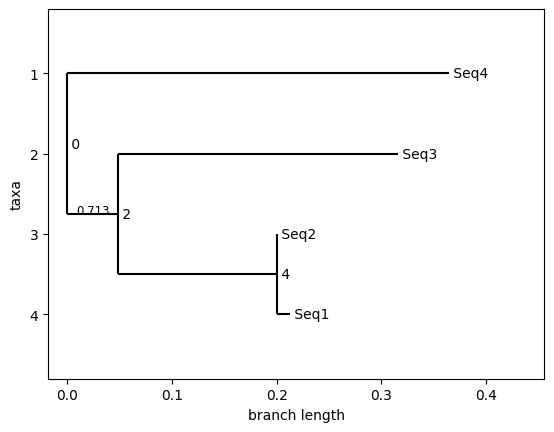

In [29]:
estimated_tree = create_tree(input_sequences)

(
    single_columns_probability, 
    paired_columns_probability,
    leaf_order,
) = get_columns_probability(
    estimated_tree,
    single_frequencies, 
    paired_frequencies, 
    single_rate_values, 
    paired_rate_values,
    input_sequences, 
)

___

## Build First Grammar And Sequence

In [30]:
total_sequence, columns = get_total_sequence(input_sequences, leaf_order)

extend_grammar(
    columns,
    pcfg,
    single_columns_probability, 
    paired_columns_probability,
    filename="./outputs/Extended"
)

## Run First Parsing

In [ ]:
# Read from extended file
extended_pcfg = PCNF("./outputs/Extended.cfg", "./outputs/Extended.pcfg")

# Run CYK algorithm
prob, table = extended_pcfg.sentence_prob(total_sequence, 0.20567728135978103, 1.9750677616424674)
print("Alignment probability:", prob)

## First Output

In [47]:
predicted_struct = {}

# Go throw parse table
draw_parse_tree(table, 1, len(list(input_sequences.values())[0]))

structure = ""
for key, val in predicted_struct.items():
    structure += val
print("First Pass Predicted Structure:",structure)

First Pass Predicted Structure: (((.....)))...............(((((................(((....))).....)))))..


___

## Build Second Grammar And Sequence

In [48]:
_input_sequences, _input_sequences__ = remove_pairs(input_sequences, structure)
# _, _columns = get_total_sequence(_input_sequences, leaf_order)

_total_sequence__, _columns = get_total_sequence(_input_sequences__, leaf_order)

extend_grammar(
    _columns,
    pcfg,
    single_columns_probability, 
    paired_columns_probability,
    filename="./outputs/Extended_"
)

extended_pcfg = PCNF("./outputs/Extended_.cfg", "./outputs/Extended_.pcfg")

## Run Second Parsing

In [49]:
# Run Flagged-CYK algorithm
prob, table = extended_pcfg.sentence_prob__(_total_sequence__, 0.9291776843985361, 1.5193196296411515, 0.9697922113434441)
print("Alignment probability:", prob)

Alignment probability: -187.2370791223484


## Second Output

In [50]:
predicted_struct = {}

draw_parse_tree(table, 1, len(list(_input_sequences.values())[0]))

_structure = ""
for key, val in predicted_struct.items():
    _structure += val
print("Second Pass Predicted Structure:",_structure)

Second Pass Predicted Structure: ...........(((((.......)))))...................


___

## Merge Results

In [51]:
__structure = ""
inner = 0
for index, char in enumerate(structure): 
    if char == ".":
        if _structure[inner] == "(":
            __structure += "["
        elif _structure[inner] == ")":
            __structure += "]"
        else:
            __structure += "."
        inner += 1
    else:
        __structure += structure[index]
        
print("Result:",__structure)

Result: (((.....)))......[[[[[....(((((...]]]]]........(((....))).....)))))..


---